# Auto-Categorization
By Trang VO

https://github.com/trang-h-vo

## Data preparation

### Load data &  libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet(str(os.getcwd()) + '/new_products_autocategorization.parquet')
print(df.shape)
df.head(3)

(10000, 9)


,create_time,article_id,brand,provider,title,description,price,category_from_provider,category_id
61322,2015-09-17 11:43:14,1023623,EDEM,Profhome,XXL Papier peint non-tissé en relief rayures d...,"<p>Fabricant: EDEM, Collection: VERSAILLES<br ...",23.95,None,449
107983,2014-03-15 05:43:46,2974561,ELEM GARDEN TECHNIC,Toupour France,3 couteaux de peintre inox,<p>3 couteaux de peintre inox</p><br /><strong...,22.39,Racine > Accueil > Outillage manuel > Le plaqu...,440
103284,2016-11-16 03:43:21,2729208,EMINZA,Eminza,Paire de voilage (60 x H120 cm) Duo Blanc Azur,Paire de voilage (60 x H120 cm) Duo Blanc Azur...,6.90,Voilage,3165


Select 500 most popular categories:

In [3]:
top_categories = df['category_id'].value_counts().reset_index()[:500]
top_categories.columns = ['category_id', 'counts']
top_categories

,category_id,counts
0,2319,176
1,449,148
2,490,121
3,3936,115
4,1866,107
...,...,...
495,1635,5
496,1104,5
497,1239,5
498,1223,5


In [4]:
# create a new dataFrame with 500 most popular categories & use it for the new experiment
df_new = df.loc[df['category_id'].isin(top_categories['category_id']), :]

# fill in missing values
df_new.fillna(' ', inplace=True)

# set text data to lower strings
for col in ['brand', 'provider', 'title', 'category_from_provider', 'description']:
    df_new[col] = df_new[col].str.lower()

### Split train & validation set

In [5]:
# define features & target
X = df_new.drop('category_id', axis=1)
y = df_new['category_id']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                                    stratify=y, random_state=1)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (6642, 8)
X_test shape: (738, 8)


In [7]:
# Concatenate X_train & X_test to have similar feature engineering
X_train['is_train'] = 1
X_test['is_train'] = 0

X_fe = pd.concat([X_train, X_test])

### Text transformer

In [8]:
X_fe['price_rounded'] = X_fe['price'].round(0).astype(int)

In [9]:
# Combine the text cols into 1 column to tokenize altogether
X_fe['full_text'] = X_fe['title'] + ' ' + X_fe['category_from_provider'] + ' ' + X_fe['description']\
                    + ' ' + X_fe['brand'] + ' ' + X_fe['provider'] + ' ' + X_fe['price_rounded'].astype(str)

**Text preprocessor**

Import libraries for text preprocessing

In [10]:
# pip install spacy-lefff
# !python3 -m spacy download fr_core_news_sm

In [11]:
import string 
from bs4 import BeautifulSoup # to remove htmml tags
import fr_core_news_sm # lemmatization

import spacy
from spacy.lang.fr import French
from spacy_lefff import LefffLemmatizer, POSTagger

In [12]:
# # alternative French stopwords list
# from nltk.corpus import stopwords
# stop_words = stopwords.words('french')

Create a French stop_words list

In [13]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
fr_stop_words = list(fr_stop)

In [14]:
# prepare for French lemmatization
nlp = fr_core_news_sm.load()

In [15]:
def text_preprocessor(doc):
    # remove html tags
    doc = doc.replace('<', ' ').replace('>', ' ')\
                .replace('/', ' ').replace('(\)', ' ')\
                .replace('.', ' ').replace(':', ' ')\
                .replace('!', ' ').replace('(', ' ')\
                .replace(')', ' ').replace(',', ' ')

    words = doc.split()
    doc_filtered = ''
    
    for w in words: 
        if (len(w)>=3) and (w not in fr_stop_words): 
            doc_filtered = doc_filtered + w + ' '
            
    tokens = nlp(doc_filtered)
    lemmas = '' 
    
    for tok in tokens:  
         # only keep nouns, verbs, adjectives & numbers
        if tok.pos_ in ('ADP', 'ADV', 'DET', 'PRON', 'PROPN', 'PUNCT'):
            pass
        elif (tok.pos_ in ('NOUN', 'ADJ', 'VERB')):
            # lemmatize
            lemmas = lemmas + tok.lemma_ + " "
        else:
            lemmas = lemmas + str(tok) + " "
    return lemmas

In [16]:
X_fe['full_text_preprocessed'] = X_fe['full_text'].apply(text_preprocessor)

## Machine Learning

### Tf-Idf & SGDClassifer

#### Tfidf Vectorizer

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(binary=True, max_features=10000)

In [18]:
full_text_vectorized = vectorizer.fit_transform(X_fe['full_text_preprocessed'])
full_text_vectorized.shape

(7380, 10000)

In [19]:
X_train_vec = full_text_vectorized.tocsr()[:6642,:]
X_test_vec = full_text_vectorized.tocsr()[6642:,:]

#### SGDClassifier

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score

In [21]:
sgd = SGDClassifier(max_iter=20000, alpha=0.0001, n_jobs=-1, random_state=123)
cv = cross_val_score(sgd, X_train_vec, y_train, scoring='accuracy',
                     cv=RepeatedKFold(n_splits=5, n_repeats=2))
print('SGD Classifier CV scores on full train set:\n', cv)
print('CV mean score: ', cv.mean())
print('CV scores std: ', cv.std())

SGD Classifier CV scores on full train set:
 [0.73137698 0.71181339 0.74021084 0.7371988  0.75903614 0.74191121
 0.73739654 0.74698795 0.7311747  0.72966867]
CV mean score:  0.7366775227320115
CV scores std:  0.011715815069054898


Get scores on the full train set using cross_val_predict:

In [22]:
y_train_pred_sgd = cross_val_predict(sgd, X_train_vec, y_train, cv=5, n_jobs=-1)
print('SGD Classifier scores on full train set:')
print('Accuracy score: ', accuracy_score(y_train, y_train_pred_sgd))
print('F1 macro score: ', f1_score(y_train, y_train_pred_sgd, average='macro'))

SGD Classifier scores on full train set:
Accuracy score:  0.7621198434206564
F1 macro score:  0.6568292204998418


Get score on the validation set:

In [23]:
sgd.fit(X_train_vec, y_train)
y_pred_sgd = sgd.predict(X_test_vec)
print('SGD scores on validation set:')
print('Accuracy score: ', accuracy_score(y_test, y_pred_sgd))
print('F1 macro score: ', f1_score(y_test, y_pred_sgd, average='macro'))

SGD scores on validation set:
Accuracy score:  0.7560975609756098
F1 macro score:  0.6302208624586539


SGD performs quite well and has no overfitting issue, given the small training set and high number of target classes.

### Neural Networks with TensorFlow/Keras
As the training set is rather small compared to the number of classes, I'll use MLP with 1 hidden layer. Other tests show that with more hidden layers, the models perform poorly.

Steps inlude:

- Use `Keras Tokenizer` to transform the text to sequences and then to matrices
- Transform the target labels before feeding to MLP
- Test a simple model
- Tune hyperparameters using Keras Tuners: `RandomSearch` & `Hyperband Tuner`.

In [25]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks
tf.random.set_seed(42)

TensorFlow version: 2.4.1


#### Keras Tokenizer

Transform text to sequences:

In [26]:
max_words = 10000
num_tokenizer = Tokenizer(num_words=max_words)

# fit on preprocessed text
num_tokenizer.fit_on_texts(X_fe['full_text_preprocessed'])
X_full_sequences = num_tokenizer.texts_to_sequences(X_fe['full_text_preprocessed'])

X_train_sequences = X_full_sequences[:6642]
X_test_sequences = X_full_sequences[6642:]

Tokenize the sequences to matrix:

In [27]:
print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=max_words)

X_train_keras = tokenizer.sequences_to_matrix(X_train_sequences, mode='binary')
X_test_keras = tokenizer.sequences_to_matrix(X_test_sequences, mode='binary')

print('X_train_keras shape:', X_train_keras.shape)
print('X_test_keras shape:', X_test_keras.shape)

Vectorizing sequence data...
X_train_keras shape: (6642, 10000)
X_test_keras shape: (738, 10000)


**Transform the target variable for keras**

In [28]:
# concaternate y_train & y_test for transformation
y_full = pd.concat([y_train, y_test], axis=0)

In [29]:
from tensorflow.keras.utils import to_categorical 
print('Convert class vector to binary class matrix (for use with categorical_crossentropy)')
nb_classes = y_full.unique().shape[0]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_full)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_keras = to_categorical(y_train_encoded, nb_classes)
y_test_keras = to_categorical(y_test_encoded, nb_classes)
print('y_train_keras shape as a binary class matrix:', y_train_keras.shape)
print('y_test_keras shape as a binary class matrix:', y_test_keras.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train_keras shape as a binary class matrix: (6642, 500)
y_test_keras shape as a binary class matrix: (738, 500)


#### MLP

In [30]:
nb_epoch = 10

nn1 = Sequential()
nn1.add(Dense(30, input_shape=(max_words,)))
nn1.add(Activation('tanh'))
# nn1.add(Dropout(0.4))

nn1.add(Dense(nb_classes))
nn1.add(Activation('softmax'))

nn1.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

history_1 = nn1.fit(X_train_keras, y_train_keras, epochs=nb_epoch, validation_split=0.1, batch_size=6, verbose=1)

Epoch 1/10
997/997 [==============================] - 7s 5ms/step - loss: 5.5999 - accuracy: 0.1620 - val_loss: 4.0524 - val_accuracy: 0.3188
Epoch 2/10
997/997 [==============================] - 4s 4ms/step - loss: 3.3339 - accuracy: 0.4340 - val_loss: 3.0665 - val_accuracy: 0.4556
Epoch 3/10
997/997 [==============================] - 4s 4ms/step - loss: 2.2759 - accuracy: 0.6090 - val_loss: 2.4747 - val_accuracy: 0.5444
Epoch 4/10
997/997 [==============================] - 4s 4ms/step - loss: 1.5575 - accuracy: 0.7499 - val_loss: 2.0972 - val_accuracy: 0.5970
Epoch 5/10
997/997 [==============================] - 4s 4ms/step - loss: 1.1101 - accuracy: 0.8344 - val_loss: 1.8334 - val_accuracy: 0.6481
Epoch 6/10
997/997 [==============================] - 4s 4ms/step - loss: 0.7448 - accuracy: 0.9068 - val_loss: 1.6529 - val_accuracy: 0.6707
Epoch 7/10
997/997 [==============================] - 4s 4ms/step - loss: 0.5091 - accuracy: 0.9451 - val_loss: 1.5117 - val_accuracy: 0.6797
Epoch 

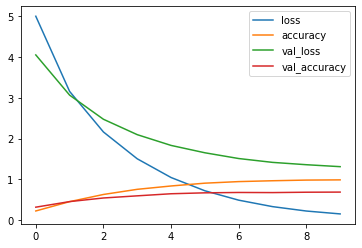

In [31]:
import matplotlib.pyplot as plt
pd.DataFrame(history_1.history).plot(figsize=(6,4)) #, marker='o'
# plt.gca().set_ylim(0,1)
plt.show()

In [32]:
score_1 = nn1.evaluate(X_test_keras, y_test_keras)

24/24 [==============================] - 0s 6ms/step - loss: 1.3606 - accuracy: 0.6829


#### Keras Tuners
- Simplified approach:
        - Using dropout to help prevent overfitting
        - Alternate number of neurons in the hidden layer, activation functions

- To search in a larger hyperparameter space: increase number of hidden layers, tune the dropout rate, optimizers, learning rate...

##### RandomSearch

Build a hypermodel

In [33]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
class ClassifierHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, HyperModel):     
        model = Sequential()
        model.add(
            Dense(units=HyperModel.Int('units', min_value=24, max_value=44, step=4, default=40),
                  activation=HyperModel.Choice(name = 'dense_activation',
                                       values = ['relu', 'tanh', 'sigmoid'],
                                       default='relu', ordered = False),
                  input_shape=input_shape)
            )
        
        model.add(
            Dropout(HyperModel.Float(name='dropout', min_value=0.2, max_value=0.6, step=0.1, default=0.5))
            )
        
        model.add(Dense(nb_classes))
        model.add(Activation('softmax'))
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',metrics=['accuracy']
            )
        
        return model

In [34]:
input_shape = (max_words,)
hypermodel = ClassifierHyperModel(input_shape)

Tuner's settings

In [35]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='val_accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2)

es_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


Launch RandomSearch

In [36]:
tuner_rs.search(X_train_keras, y_train_keras,
                epochs=50,
                validation_split=0.1,
                batch_size=8,
                callbacks=[es_callback],
                verbose=1,
                seed=42)

INFO:tensorflow:Oracle triggered exit


In [37]:
tuner_rs.results_summary(5)

Results summary
Results in ./untitled_project
Showing 5 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 32
dense_activation: tanh
dropout: 0.4000000000000001
Score: 0.693233072757721
Trial summary
Hyperparameters:
units: 36
dense_activation: relu
dropout: 0.30000000000000004
Score: 0.6902255713939667
Trial summary
Hyperparameters:
units: 28
dense_activation: tanh
dropout: 0.4000000000000001
Score: 0.6887218058109283
Trial summary
Hyperparameters:
units: 32
dense_activation: tanh
dropout: 0.6000000000000001
Score: 0.68721804022789
Trial summary
Hyperparameters:
units: 36
dense_activation: relu
dropout: 0.4000000000000001
Score: 0.6857143044471741


Get best model by RandomSearch & check accuracy score on the test set:

In [38]:
best_model_rs = tuner_rs.get_best_models(num_models=1)[0]
loss, mse = best_model_rs.evaluate(X_test_keras, y_test_keras)

24/24 [==============================] - 2s 12ms/step - loss: 1.6383 - accuracy: 0.6277


Using the hyperparameters found by RandomSearch, we'll train the model again, this time using smaller batch size, higher number of epochs while still keep the callbacks function to prevent overfitting.

In [39]:
nn_rs = Sequential()
nn_rs.add(Dense(32, input_shape=(max_words,)))
nn_rs.add(Activation('tanh'))
nn_rs.add(Dropout(0.4))

nn_rs.add(Dense(nb_classes))
nn_rs.add(Activation('softmax'))

nn_rs.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

es_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

history_rs = nn_rs.fit(X_train_keras, y_train_keras, epochs=30, validation_split=0.1,
                      callbacks=[es_callback], batch_size=2, verbose=1)

Epoch 1/30
2989/2989 [==============================] - 17s 5ms/step - loss: 5.4689 - accuracy: 0.1507 - val_loss: 3.9435 - val_accuracy: 0.3579
Epoch 2/30
2989/2989 [==============================] - 13s 4ms/step - loss: 3.3171 - accuracy: 0.4288 - val_loss: 3.1019 - val_accuracy: 0.4602
Epoch 3/30
2989/2989 [==============================] - 11s 4ms/step - loss: 2.4345 - accuracy: 0.5579 - val_loss: 2.5934 - val_accuracy: 0.5398
Epoch 4/30
2989/2989 [==============================] - 12s 4ms/step - loss: 1.8116 - accuracy: 0.6643 - val_loss: 2.2466 - val_accuracy: 0.5970
Epoch 5/30
2989/2989 [==============================] - 11s 4ms/step - loss: 1.4450 - accuracy: 0.7405 - val_loss: 1.9856 - val_accuracy: 0.6180
Epoch 6/30
2989/2989 [==============================] - 11s 4ms/step - loss: 1.1173 - accuracy: 0.8097 - val_loss: 1.8164 - val_accuracy: 0.6571
Epoch 7/30
2989/2989 [==============================] - 10s 3ms/step - loss: 0.8946 - accuracy: 0.8517 - val_loss: 1.6711 - val_ac

In [40]:
loss, mse = nn_rs.evaluate(X_test_keras, y_test_keras)

24/24 [==============================] - 0s 5ms/step - loss: 1.3983 - accuracy: 0.7005


##### Hyperband Tuner

In [41]:
from kerastuner.tuners.hyperband import Hyperband

In [44]:
# tuner settings
tuner_hb = Hyperband(hypermodel,
                     max_epochs=35,
                     objective='val_accuracy',
                     factor=3,
                     seed=42,
                     executions_per_trial=2,
                     directory='hyperband_tuner')

hb_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

# launch tuning process
tuner_hb.search(X_train_keras, y_train_keras,
                epochs=35,
                validation_split=0.1,
                callbacks=[hb_callback],
                batch_size=8,
                verbose=1)

Trial 90 Complete [00h 02m 50s]
val_accuracy: 0.6586466133594513

Best val_accuracy So Far: 0.7248120307922363
Total elapsed time: 01h 08m 27s
INFO:tensorflow:Oracle triggered exit


In [45]:
tuner_hb.results_summary(3)

Results summary
Results in hyperband_tuner/untitled_project
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 40
dense_activation: tanh
dropout: 0.2
tuner/epochs: 35
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 771b6571cd69176a07a8019fa3a704f7
Score: 0.7248120307922363
Trial summary
Hyperparameters:
units: 40
dense_activation: tanh
dropout: 0.30000000000000004
tuner/epochs: 35
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 88006f1a3993802fcbefa53be4c01578
Score: 0.7210526466369629
Trial summary
Hyperparameters:
units: 40
dense_activation: tanh
dropout: 0.6000000000000001
tuner/epochs: 35
tuner/initial_epoch: 12
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: e46360c9fc380a9014ad2d39183bc472
Score: 0.7180451154708862


In [46]:
best_hyperparameters_hb = tuner_hb.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters_hb.values)

{'units': 40, 'dense_activation': 'tanh', 'dropout': 0.2, 'tuner/epochs': 35, 'tuner/initial_epoch': 12, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '771b6571cd69176a07a8019fa3a704f7'}


In [47]:
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
loss_hb, mse_hb = best_model_hb.evaluate(X_test_keras, y_test_keras)

24/24 [==============================] - 0s 3ms/step - loss: 1.3165 - accuracy: 0.6830


Using the hyperparameters found by Hyperband, we'll train the model again, this time using smaller batch size, higher number of epochs while still keep the callbacks function to prevent overfitting.

In [48]:
nn_hb = Sequential()
nn_hb.add(Dense(40, input_shape=(max_words,)))
nn_hb.add(Activation('tanh'))
nn_hb.add(Dropout(0.2))

nn_hb.add(Dense(nb_classes))
nn_hb.add(Activation('softmax'))

nn_hb.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])


hb_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
    )

history_hb = nn_hb.fit(X_train_keras, y_train_keras, epochs=50,
                       callbacks=[hb_callback],
                       validation_split=0.1, batch_size=2, verbose=1)

Epoch 1/50
2989/2989 [==============================] - 14s 4ms/step - loss: 5.2501 - accuracy: 0.1960 - val_loss: 3.4356 - val_accuracy: 0.4180
Epoch 2/50
2989/2989 [==============================] - 11s 4ms/step - loss: 2.5753 - accuracy: 0.5530 - val_loss: 2.4646 - val_accuracy: 0.5549
Epoch 3/50
2989/2989 [==============================] - 13s 4ms/step - loss: 1.5181 - accuracy: 0.7419 - val_loss: 1.9611 - val_accuracy: 0.6150
Epoch 4/50
2989/2989 [==============================] - 12s 4ms/step - loss: 0.9084 - accuracy: 0.8579 - val_loss: 1.6442 - val_accuracy: 0.6632
Epoch 5/50
2989/2989 [==============================] - 11s 4ms/step - loss: 0.5351 - accuracy: 0.9342 - val_loss: 1.4695 - val_accuracy: 0.6857
Epoch 6/50
2989/2989 [==============================] - 11s 4ms/step - loss: 0.3034 - accuracy: 0.9693 - val_loss: 1.3787 - val_accuracy: 0.6902
Epoch 7/50
2989/2989 [==============================] - 11s 4ms/step - loss: 0.1903 - accuracy: 0.9772 - val_loss: 1.3456 - val_ac

In [49]:
loss_best_hb, accuracy_best_hb = nn_hb.evaluate(X_test_keras, y_test_keras)

24/24 [==============================] - 0s 9ms/step - loss: 1.4185 - accuracy: 0.7222


**Make final predictions**

In [50]:
# predictions_nn = np.argmax(nn_hb.predict(new_data), axis=-1)

# # reverse the encoding to the initial labels
# y_pred_nn = encoder.inverse_transform(predictions_nn)

Overall, for this data set, SGD performs better than 1 hidden layer MLP. However, with larger training set, more complex models like MLP may detect patterns better.

Further improvement on MLP can be explored by increasing number of hidden layers and searching within a larger hyperparameter space.